# Classifyinng Breast Mass as Benign or Malignant 

## Setup

We begin by loading in all necessary packages, reading in the data, and defining helper functions.

In [8]:
# !pip install imblearn

In [12]:
# Data libraries
import pandas as pd
import numpy as np
from scipy import stats

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Neural network libraries
import torch
from torch import nn, Tensor
import torch.optim as optim
from typing import Iterable

# sklearn modules
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve, average_precision_score, PrecisionRecallDisplay
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, cross_validate
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold, StratifiedKFold,PredefinedSplit
from sklearn import set_config
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC 

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree, metrics

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load dataset
df = pd.read_csv('breast-cancer-data.csv')

df.shape

(569, 32)

In [10]:
def pretty_confusion_matrix(confmat, labels, title, labeling=False, highlight_indexes=[]):
    """
    Create and plot a confusion matrix which is
    helpful for classification tasks
    """
    labels_list = [["TN", "FP"], ["FN", "TP"]]
    
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.matshow(confmat, cmap="YlGnBu", alpha=0.7)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            if labeling:
                label = str(confmat[i, j])+" ("+labels_list[i][j]+")"
            else:
                label = confmat[i, j]
            
            if [i,j] in highlight_indexes:
                ax.text(x=j, y=i, s=label, va='center', ha='center',
                        weight = "bold", fontsize=18, color='#32618b')
            else:
                ax.text(x=j, y=i, s=label, va='center', ha='center')
       
    # change the labels
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        ax.set_xticklabels(['']+[labels[0], labels[1]])
        ax.set_yticklabels(['']+[labels[0], labels[1]])

    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    ax.xaxis.set_label_position('top')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

In [11]:
def get_metrics(matrix, y_test, predictions):
    """Calculate metrics using confusion matrix"""
    
    tpr = round((matrix[1][1])/(matrix[1][0] + matrix[1][1]),4)
    fpr = round((matrix[0][1])/(matrix[0][0] + matrix[0][1]),4)
    
    accuracy = round((matrix[0][0] + matrix[1][1])/(matrix[0][0] + matrix[0][1] + matrix[1][0] + matrix[1][1]),4)
    precision = round((matrix[1][1])/(matrix[1][1] + matrix[0][1]),4)
    f1_score = round((2*((precision*tpr)/(precision+tpr))),4)
    auc = round(metrics.roc_auc_score(y_test, predictions),4)

    print('-------\nMetrics\n-------')
    print(f'Recall: {tpr}.')
    print(f'False Positive Rate : {fpr}.')
    print(f'Precision Rate : {precision}.')
    print(f'Accuracy : {accuracy}.')
    print(f'F1 Score : {f1_score}.')
    print(f'ROC Score: {auc}.')

## Exploratory Data Analysis and Feature Engineering

In [3]:
rng = 21701

TRAIN_SIZE = 0.7
TEST_SIZE = 0.15
VALID_SIZE = 1 - TRAIN_SIZE - TEST_SIZE
VAL_TEST_RATIO = VALID_SIZE / (VALID_SIZE + TEST_SIZE)

# Separate the target variable
X = df.drop('diagnosis', axis=1)
y = df['diagnosis']

print(f"X has shape {X.shape} and y has shape {y.shape}")

# Split into train, test and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE+VALID_SIZE, random_state=rng, shuffle=True)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=VAL_TEST_RATIO, random_state=rng, shuffle=True)

print(f"Training set has {X_train.shape[0]} datapoints. \nTesting set has {X_test.shape[0]} datapoints. \nValidation set has {X_val.shape[0]} datapoints.")


X has shape (569, 31) and y has shape (569,)
Training set has 398 datapoints. 
Testing set has 85 datapoints. 
Validation set has 86 datapoints.


In [4]:
df.isnull().sum()

print(f"We have {int(df.isnull().sum().sum())} missing values in the dataset.")

We have 0 missing values in the dataset.


In [5]:
# Visualise numerical columns in data
descr_stats = X_train.describe(include = [np.number]).round(2)
s = descr_stats.style.format('{:.0f}')

s

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,398,398,398,398,398,398,398,398,398,398,398,398,398,398,398,398,398,398,398,398,398,398,398,398,398,398,398,398,398,398,398
mean,25129728,14,19,91,643,0,0,0,0,0,0,0,1,3,39,0,0,0,0,0,0,16,26,106,856,0,0,0,0,0,0
std,103366704,3,4,24,345,0,0,0,0,0,0,0,1,2,43,0,0,0,0,0,0,5,6,32,545,0,0,0,0,0,0
min,8913,8,10,48,179,0,0,0,0,0,0,0,0,1,7,0,0,0,0,0,0,9,12,57,240,0,0,0,0,0,0
25%,869232,12,16,74,408,0,0,0,0,0,0,0,1,2,17,0,0,0,0,0,0,13,21,83,499,0,0,0,0,0,0
50%,905511,13,19,86,540,0,0,0,0,0,0,0,1,2,23,0,0,0,0,0,0,15,25,97,672,0,0,0,0,0,0
75%,8897864,16,22,104,762,0,0,0,0,0,0,0,1,3,44,0,0,0,0,0,0,18,30,123,1014,0,0,0,0,0,0
max,911320502,28,39,188,2499,0,0,0,0,0,0,3,4,22,526,0,0,0,0,0,0,33,50,221,3432,0,1,1,0,1,0


Text(0.5, 1.015, 'Histograms of Each Feature in the Dataset')

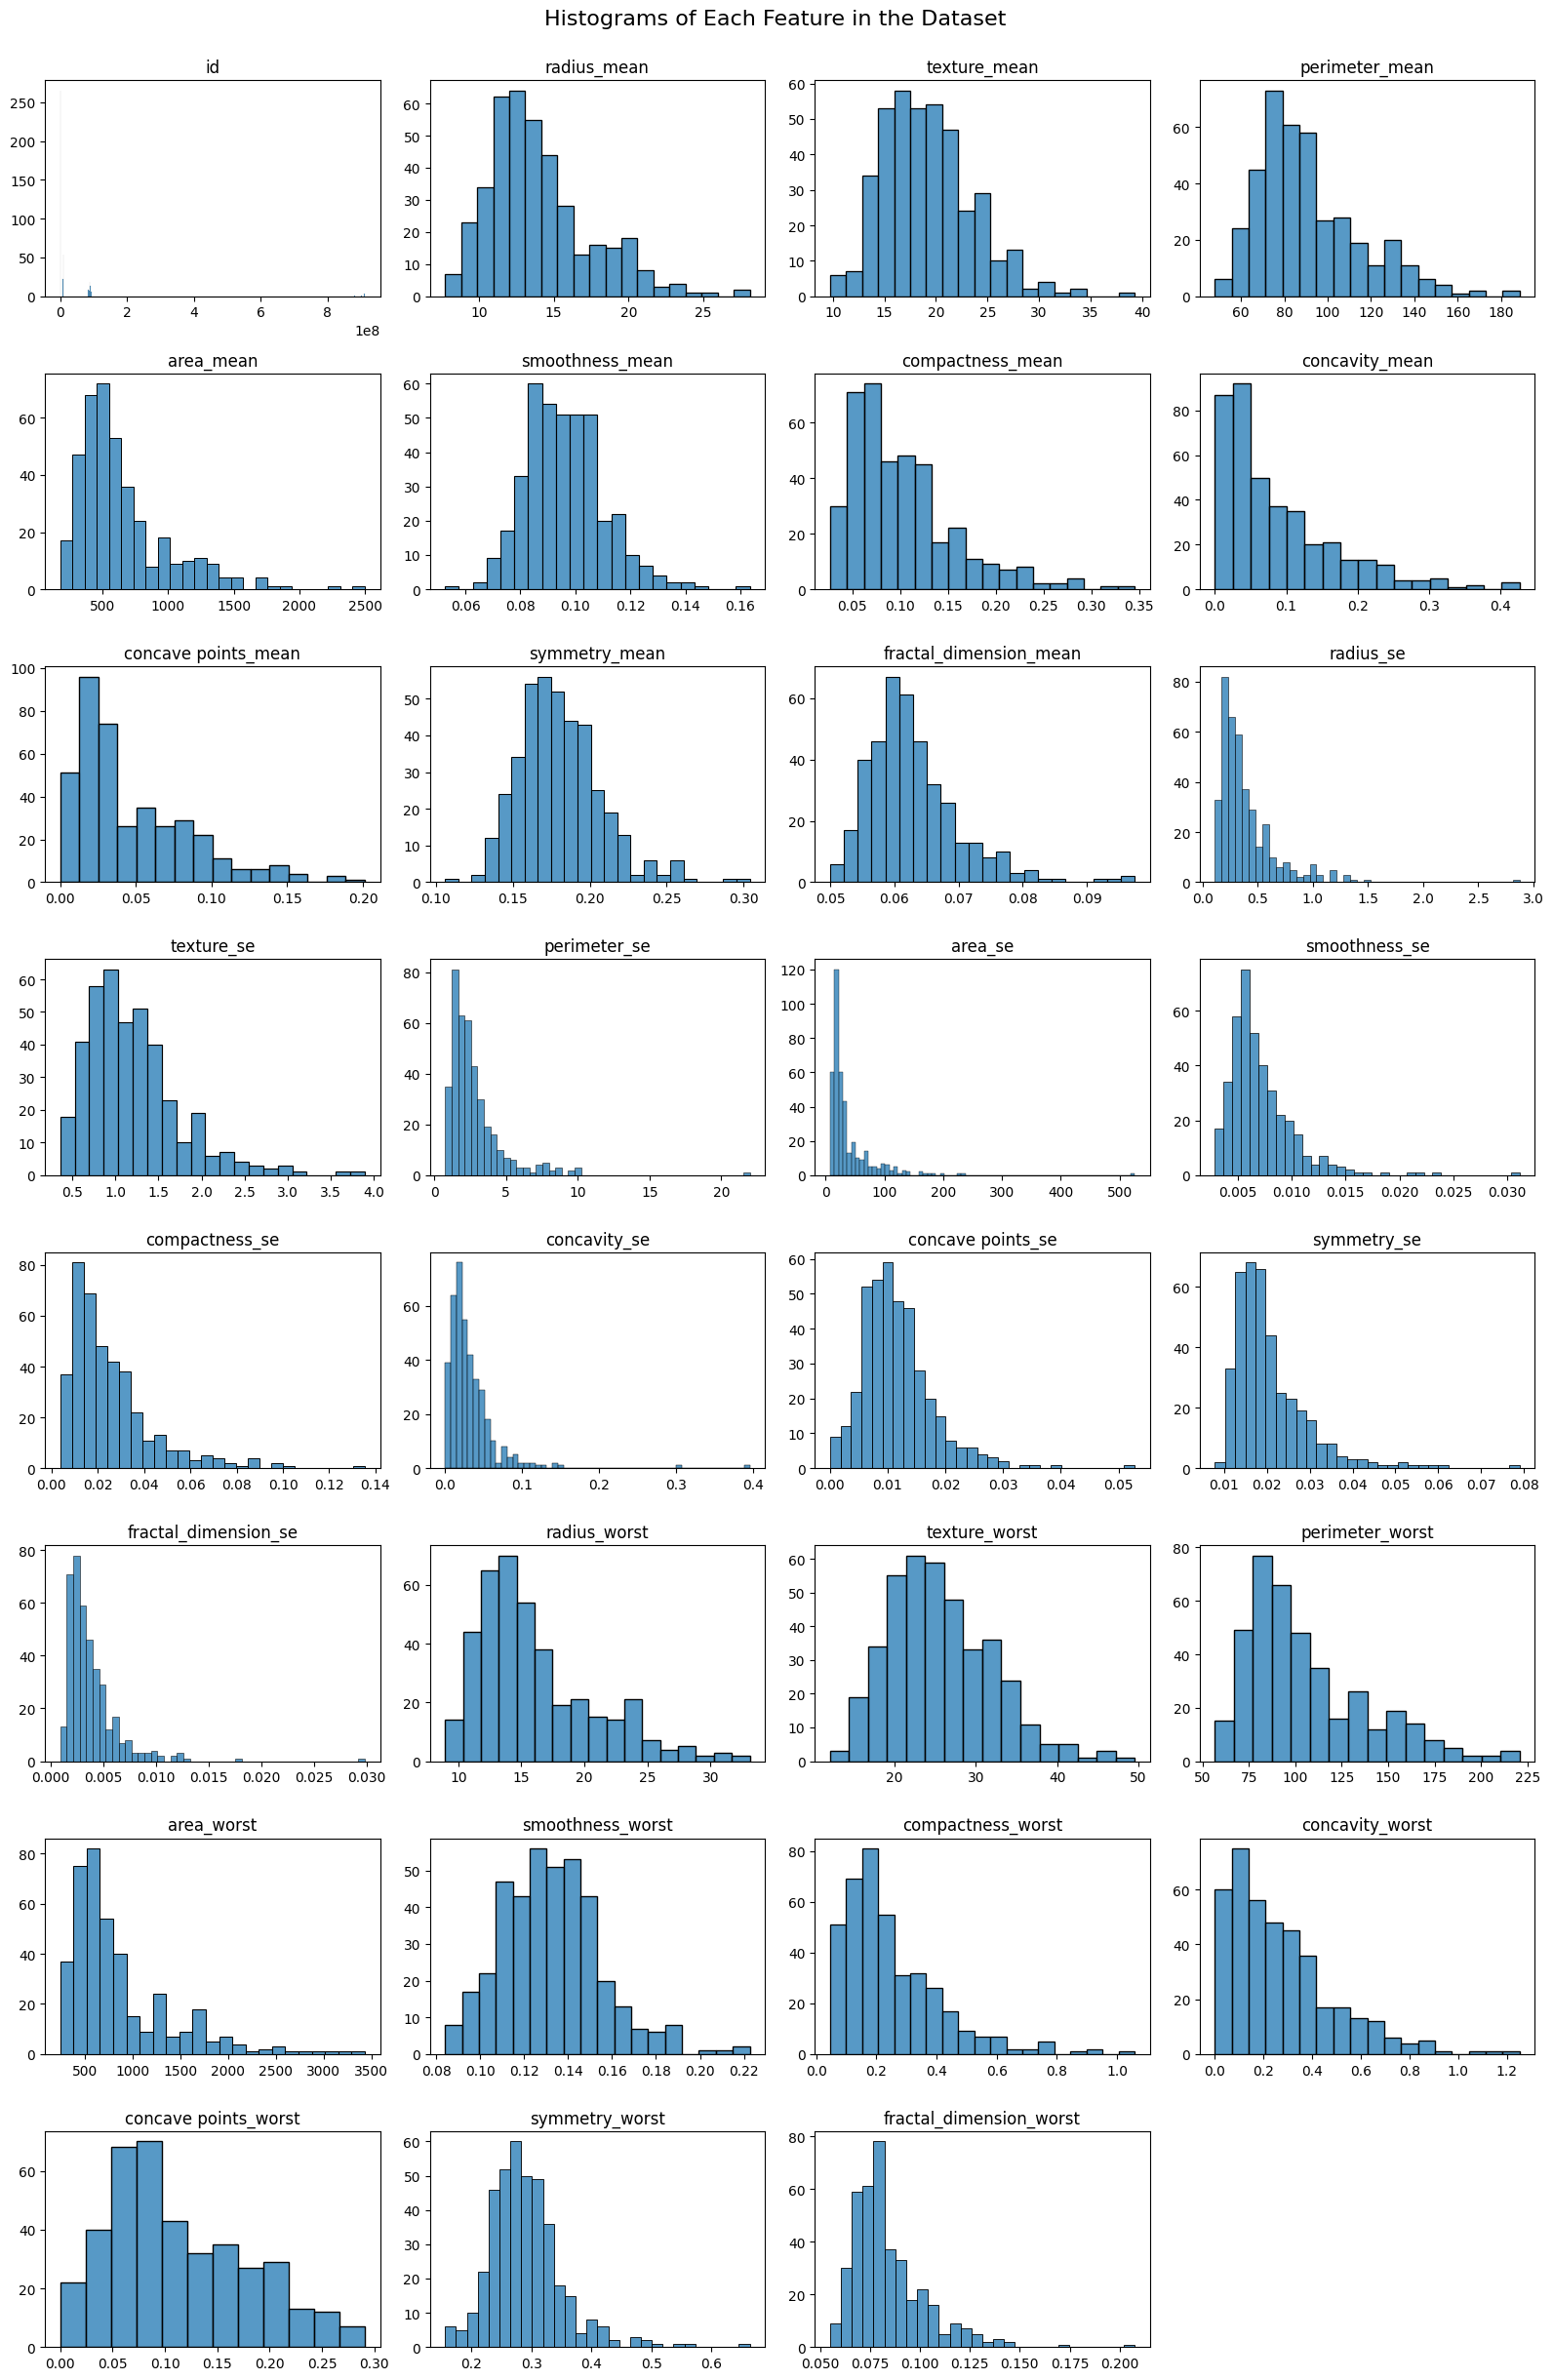

In [6]:
# Figure plot area and settings
fig, ax = plt.subplots(figsize = (16, 24))
ax.set_frame_on(False)
ax.set_xticks([])
ax.set_yticks([])

# Plot histograms for each feature
for n, col in enumerate(X_train.columns):
    plt.subplot(8, 4, n+1)
    a = sns.histplot(X_train[col],ax = plt.gca())
    a.set(xlabel=None, ylabel=None)
    a.set_facecolor('white')
    plt.title(col)
plt.tight_layout()
plt.suptitle("Histograms of Each Feature in the Dataset", fontsize=16, y=1.015)

(array([253., 145.]),
 array([0. , 0.5, 1. ]),
 <BarContainer object of 2 artists>)

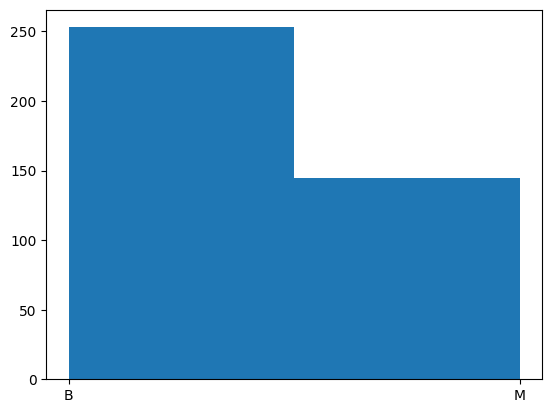

In [7]:
plt.hist(y_train, bins=2)

We have no missing values in the data set and no feature is highly skewed. We move to trying a baseline model using logistic regression.

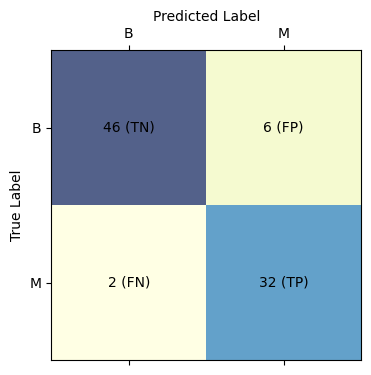

-------
Metrics
-------
Recall: 0.9412.
False Positive Rate : 0.1154.
Precision Rate : 0.8421.
Accuracy : 0.907.
F1 Score : 0.8889.
ROC Score: 0.9129.


In [31]:
clf = LogisticRegression(random_state=rng, penalty='l2').fit(X_train, y_train)

predictions = clf.predict(X_val)

# Get the confusion matrix as a numpy array
confmat = confusion_matrix(y_true=y_val, y_pred=predictions)

# Plot the confusion matrix  
pretty_confusion_matrix(confmat, ['B', 'M'], "",  labeling = True)

# Print out metrics
get_metrics(confmat, y_test=y_val, predictions=predictions)

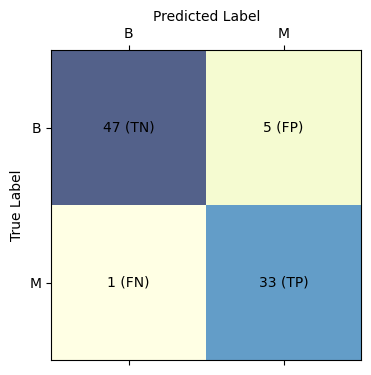

-------
Metrics
-------
Recall: 0.9706.
False Positive Rate : 0.0962.
Precision Rate : 0.8684.
Accuracy : 0.9302.
F1 Score : 0.9167.
ROC Score: 0.9372.


0.949748743718593

In [39]:
rand_forest = RandomForestClassifier(max_depth=3, random_state=rng, oob_score=True).fit(X_train, y_train)

predictions = rand_forest.predict(X_val)

# Get the confusion matrix as a numpy array
confmat = confusion_matrix(y_true=y_val, y_pred=predictions)

# Plot the confusion matrix  
pretty_confusion_matrix(confmat, ['B', 'M'], "",  labeling = True)

# Print out metrics
get_metrics(confmat, y_test=y_val, predictions=predictions)

rand_forest.oob_score_

In [40]:
n_estimators=[1,10,100,1000]
max_depth=[2,3,4]

def oob_printer(n_estimators, max_depth, X, y):
    for depth in max_depth:
        for n_estimator in n_estimators:

            tree_clf = RandomForestClassifier(n_estimators=n_estimator, max_depth = depth,
                                              random_state=rng, oob_score=True)
            
            trained_tree = tree_clf.fit(X, y)
            out_of_bag_score=round(trained_tree.oob_score_,3)

            print(f'The out of bag score for max_depth={depth} and n_estimators={n_estimator} is {out_of_bag_score}.')

oob_printer(n_estimators=n_estimators, max_depth=max_depth, X=X_train, y=y_train)

The out of bag score for max_depth=2 and n_estimators=1 is 0.726.
The out of bag score for max_depth=2 and n_estimators=10 is 0.91.
The out of bag score for max_depth=2 and n_estimators=100 is 0.937.
The out of bag score for max_depth=2 and n_estimators=1000 is 0.942.
The out of bag score for max_depth=3 and n_estimators=1 is 0.734.
The out of bag score for max_depth=3 and n_estimators=10 is 0.935.
The out of bag score for max_depth=3 and n_estimators=100 is 0.95.
The out of bag score for max_depth=3 and n_estimators=1000 is 0.96.
The out of bag score for max_depth=4 and n_estimators=1 is 0.741.
The out of bag score for max_depth=4 and n_estimators=10 is 0.94.
The out of bag score for max_depth=4 and n_estimators=100 is 0.957.
The out of bag score for max_depth=4 and n_estimators=1000 is 0.957.
